In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import time
from functools import wraps
from typing import Callable, Tuple, TypeVar
import matplotlib.pyplot as plt

In [95]:
# hyperparameters

seed = 0
SNR = 20
batch_size = 64
lstsq_method = 'non-linear' # 'linear' or 'non-linear'
lr = 1e-3
threshold_eigval = 3.5
train_percent = 0.8

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
# file names

d_tensors_file = f'{lstsq_method} sim d_tensors.pt'
signals_file = f'{lstsq_method} sim signals.pt'
noisy_signals_file = f'{lstsq_method} sim noisy_signals {SNR}.pt'

In [97]:
# load d_tensors, signals and noisy_signals

d_tensors = torch.load(d_tensors_file)
signals = torch.load(signals_file)
noisy_signals = torch.load(noisy_signals_file)

d_tensors.shape, signals.shape, noisy_signals.shape

(torch.Size([338645, 3, 3]),
 torch.Size([338645, 104]),
 torch.Size([338645, 104]))

In [98]:
# filter d_tensors, signals and noisy_signals by maximum eigenvalue lower than 3.5

eigenvalues = torch.linalg.eigvalsh(d_tensors)
filter_indices = torch.where(eigenvalues[:,-1] <= threshold_eigval)[0]

print(f'Threshold eigenvalue of {threshold_eigval} will keep {100 * len(filter_indices) / len(eigenvalues):.2f}% of the data.')

d_tensors = d_tensors[filter_indices]
signals = signals[filter_indices]
noisy_signals = noisy_signals[filter_indices]

d_tensors.shape, signals.shape, noisy_signals.shape

Threshold eigenvalue of 3.5 will keep 99.61% of the data.


(torch.Size([337329, 3, 3]),
 torch.Size([337329, 104]),
 torch.Size([337329, 104]))

In [39]:
# shuffle and split indices

num_data = len(d_tensors)
num_train = int(train_percent * num_data)
num_val = num_data - num_train

generator = torch.Generator().manual_seed(seed)
indices = torch.randperm(num_data, generator=generator)

train_indices = indices[:num_train]
val_indices = indices[num_train:]

In [40]:
class DiffusionDataset(Dataset):
    
    def __init__(self, d_tensors: torch.Tensor, signals: torch.Tensor, noisy_signals: torch.Tensor):
        super().__init__()
        self.d_tensors = d_tensors
        self.signals = signals
        self.noisy_signals = noisy_signals

    def __len__(self):
        return self.d_tensors.shape[0]

    def __getitem__(self, idx):
        return self.d_tensors[idx], self.signals[idx], self.noisy_signals[idx]

In [41]:
# create the datasets

train_dataset = DiffusionDataset(d_tensors[train_indices], signals[train_indices], noisy_signals[train_indices])
val_dataset = DiffusionDataset(d_tensors[val_indices], signals[val_indices], noisy_signals[val_indices])

In [42]:
# create the dataloaders

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [43]:
class PolarDiffusionNet(torch.nn.Module):
    
    def __init__(self, input_size: int):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = 64
        self.output_size = 6

        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.input_size, self.hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_size, self.hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(self.hidden_size, self.output_size)
        )

    def forward(self, net_input: torch.Tensor) -> torch.Tensor:
        net_output = self.net(net_input)
        activated_net_output = self.activate(net_output)
        predictions = self.reconstruct(activated_net_output)
        return predictions
    
    def activate(self, net_output: torch.Tensor) -> torch.Tensor:
        
        # Split the tensor into individual elements
        x_angles, y_angles, z_angles, eig_val_1, eig_val_2_over_1, eig_val_3_over_2 = torch.split(net_output, split_size_or_sections=1, dim=1)
        
        # Apply different activation functions to each element
        x_angles = torch.sigmoid(x_angles)
        y_angles = torch.sigmoid(y_angles)
        z_angles = torch.sigmoid(z_angles)
        eig_val_1 = torch.sigmoid(eig_val_1)
        eig_val_2_over_1 = torch.sigmoid(eig_val_2_over_1)
        eig_val_3_over_2 = torch.sigmoid(eig_val_3_over_2)

        # Return the activated tensor
        activated_net_output = torch.cat((x_angles, y_angles, z_angles, eig_val_1, eig_val_2_over_1, eig_val_3_over_2), dim=1)
        
        return activated_net_output
    
    def reconstruct(self, activated_net_output: torch.Tensor) -> torch.Tensor:
        
        # Split the tensor into individual elements
        x_angles, y_angles, z_angles, eig_val_1, eig_val_2_over_1, eig_val_3_over_2 = torch.split(activated_net_output, split_size_or_sections=1, dim=1)      
        
        # Compute angles
        x_angles = x_angles.squeeze() * 2 * torch.pi
        y_angles = y_angles.squeeze() * 2 * torch.pi
        z_angles = z_angles.squeeze() * 2 * torch.pi
        
        # Compute eigenvalues
        eig_val_1 = eig_val_1.squeeze() * 3.5
        eig_val_2 = eig_val_1 * eig_val_2_over_1.squeeze()
        eig_val_3 = eig_val_2 * eig_val_3_over_2.squeeze()

        # Create the roation matrices around the x axis.
        R_x = torch.zeros((x_angles.shape[0], 3, 3))
        R_x[:, 0, 0] = 1
        R_x[:, 1, 1] = torch.cos(x_angles)
        R_x[:, 1, 2] = -torch.sin(x_angles)
        R_x[:, 2, 1] = torch.sin(x_angles)
        R_x[:, 2, 2] = torch.cos(x_angles)

        # Create the roation matrices around the y axis.
        R_y = torch.zeros((y_angles.shape[0], 3, 3))
        R_y[:, 0, 0] = torch.cos(y_angles)
        R_y[:, 0, 2] = torch.sin(y_angles)
        R_y[:, 1, 1] = 1
        R_y[:, 2, 0] = -torch.sin(y_angles)
        R_y[:, 2, 2] = torch.cos(y_angles)

        # Create the roation matrices around the z axis.
        R_z = torch.zeros((z_angles.shape[0], 3, 3))
        R_z[:, 0, 0] = torch.cos(z_angles)
        R_z[:, 0, 1] = -torch.sin(z_angles)
        R_z[:, 1, 0] = torch.sin(z_angles)
        R_z[:, 1, 1] = torch.cos(z_angles)
        R_z[:, 2, 2] = 1

        # Calculate the rotation matrices.
        R = torch.bmm(R_z, torch.bmm(R_y, R_x))

        # Calculate the diagonal matrix of eigenvalues.
        eig_vals = torch.zeros((eig_val_1.shape[0], 3, 3))
        eig_vals[:, 0, 0] = eig_val_1
        eig_vals[:, 1, 1] = eig_val_2
        eig_vals[:, 2, 2] = eig_val_3

        # Reconstruct the diffusion tensors.
        D = torch.bmm(R, torch.bmm(eig_vals, R.transpose(1, 2)))

        return D

In [44]:
T = TypeVar('T')

def timer(func: Callable[..., T]) -> Callable[..., Tuple[T, float]]:
    @wraps(func)
    def wrapper(*args, **kwargs) -> Tuple[T, float]:
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        return result, execution_time
    return wrapper

In [45]:
@timer
def train(train_loader, model, loss_fn, optimizer, device):

    epoch_loss = 0.0
    model.train()
    
    for batch_d_tensors, batch_signals, batch_noisy_signals in train_loader:
        
        batch_d_tensors = batch_d_tensors.to(device)
        batch_signals = batch_signals.to(device)
        batch_noisy_signals = batch_noisy_signals.to(device)

        pred_d_tensors = model(batch_noisy_signals)
        
        batch_loss = loss_fn(pred_d_tensors, batch_d_tensors)
    
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()
        
    epoch_loss /= len(train_loader)

    return epoch_loss

In [46]:
@timer
def validate(val_loader, model, loss_fn, device):

    epoch_loss = 0.0
    model.eval()
    
    with torch.no_grad():
        
        for batch_d_tensors, batch_signals, batch_noisy_signals in val_loader:

            batch_d_tensors = batch_d_tensors.to(device)
            batch_signals = batch_signals.to(device)
            batch_noisy_signals = batch_noisy_signals.to(device)

            pred_d_tensors = model(batch_noisy_signals)

            batch_loss = loss_fn(pred_d_tensors, batch_d_tensors)

            epoch_loss += batch_loss.item()
        
    epoch_loss /= len(val_loader)

    return epoch_loss

In [47]:
# (re)set the model, loss function, optimizer and buffers

polar_dnet = PolarDiffusionNet(input_size=signals.shape[1]).to(device)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(polar_dnet.parameters(), lr=lr)

train_losses = []
val_losses = []
epochs = []

In [55]:
# train the model

num_epochs = 10

last_epoch = epochs[-1] if epochs else 0

for epoch in range(last_epoch, last_epoch + num_epochs):
        
      epoch_train_loss, train_time = train(train_loader, polar_dnet, loss_fn, optimizer, device)
      epoch_val_loss, eval_time = validate(val_loader, polar_dnet, loss_fn, device)

      train_losses.append(epoch_train_loss)
      val_losses.append(epoch_val_loss)
      epochs.append(epoch + 1)

      print(f'Epoch: {epoch + 1}/{last_epoch + num_epochs} - ',
            f'Train Loss: {epoch_train_loss:.8f} - ',
            f'Eval Loss: {epoch_val_loss:.8f} - ',
            f'Train Time: {train_time:.2f} - ',
            f'Eval Time: {eval_time:.2f}')

Epoch: 31/40 -  Train Loss: 0.00367030 -  Eval Loss: 0.00356978 -  Train Time: 26.45 -  Eval Time: 2.29
Epoch: 32/40 -  Train Loss: 0.00361330 -  Eval Loss: 0.00370803 -  Train Time: 29.01 -  Eval Time: 2.42
Epoch: 33/40 -  Train Loss: 0.00365101 -  Eval Loss: 0.00346676 -  Train Time: 35.47 -  Eval Time: 2.92
Epoch: 34/40 -  Train Loss: 0.00362974 -  Eval Loss: 0.00365119 -  Train Time: 26.14 -  Eval Time: 2.51
Epoch: 35/40 -  Train Loss: 0.00364886 -  Eval Loss: 0.00335596 -  Train Time: 31.25 -  Eval Time: 2.52
Epoch: 36/40 -  Train Loss: 0.00362433 -  Eval Loss: 0.00355270 -  Train Time: 37.87 -  Eval Time: 2.79
Epoch: 37/40 -  Train Loss: 0.00361507 -  Eval Loss: 0.00383372 -  Train Time: 23.02 -  Eval Time: 1.87
Epoch: 38/40 -  Train Loss: 0.00359179 -  Eval Loss: 0.00393111 -  Train Time: 22.82 -  Eval Time: 1.77
Epoch: 39/40 -  Train Loss: 0.00366180 -  Eval Loss: 0.00365256 -  Train Time: 21.27 -  Eval Time: 1.41
Epoch: 40/40 -  Train Loss: 0.00361063 -  Eval Loss: 0.00366227 

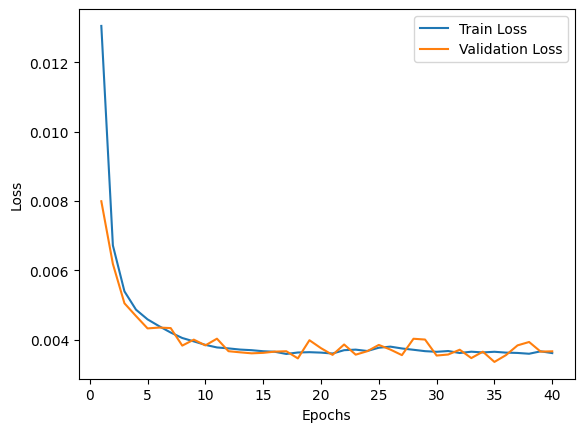

In [56]:
# plot the losses with epochs_list as x-axis

plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()